Задача: Написать классификатор, который по изображению определяет наиболее вероятностный шрифт из ['arial', 'calibri', 'liberation serif', 'times new roman', 'verdana']

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Download the required libraries
from __future__ import print_function, division

import numpy as np
import torch
import torchvision
import os
import copy
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.onnx
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

%matplotlib inline

plt.ion()   # interactive moden

In [3]:
#get address
data_dir="/content/drive/MyDrive/datasets/"

#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):

    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)


In [5]:
riterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cpu")

**Transer Learning**

pretrained model Renset18 train datasets

In [6]:
#Data scaled and normalization for training and testing for resnet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Датасет: 
  части изображения единого шрифта разного размера (для обучения - 538 изображений, для теста - 194)

 

In [7]:
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")

Classes:  ['arial', 'calibri', 'liberation serif', 'times new roman', 'verdana']
The datasest have:  {'train': 538, 'test': 194}  images


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Create new image show function for new transofration 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Примеры подаваемых изображений на обучение


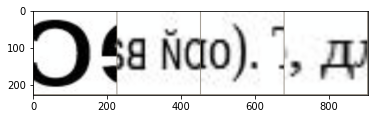

arial arial liberation serif liberation serif


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print('Примеры подаваемых изображений на обучение')
# show images
imshow_resNet18(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Функция обучения модели

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Параметры для обучения модели

In [11]:
# Let's prepare the parameters for training the model
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Обучение модели

In [12]:
#Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3742 Acc: 0.4461
test Loss: 1.3098 Acc: 0.5155
Epoch 1/24
----------
train Loss: 1.1110 Acc: 0.5985
test Loss: 0.7507 Acc: 0.7165
Epoch 2/24
----------
train Loss: 1.0120 Acc: 0.6283
test Loss: 0.7217 Acc: 0.7268
Epoch 3/24
----------
train Loss: 0.7765 Acc: 0.7045
test Loss: 0.9111 Acc: 0.6856
Epoch 4/24
----------
train Loss: 0.8131 Acc: 0.7305
test Loss: 0.6953 Acc: 0.7423
Epoch 5/24
----------
train Loss: 0.6643 Acc: 0.7881
test Loss: 0.9122 Acc: 0.6289
Epoch 6/24
----------
train Loss: 0.6162 Acc: 0.7695
test Loss: 0.6317 Acc: 0.7474
Epoch 7/24
----------
train Loss: 0.4555 Acc: 0.8327
test Loss: 0.4528 Acc: 0.8351
Epoch 8/24
----------
train Loss: 0.3588 Acc: 0.8643
test Loss: 0.4928 Acc: 0.8247
Epoch 9/24
----------
train Loss: 0.3804 Acc: 0.8755
test Loss: 0.4333 Acc: 0.8351
Epoch 10/24
----------
train Loss: 0.3460 Acc: 0.8662
test Loss: 0.4150 Acc: 0.8557
Epoch 11/24
----------
train Loss: 0.3322 Acc: 0.8736
test Loss: 0.4029 Acc: 0.8557
Ep

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.0051,  1.7434, -3.2045,  6.6171, -5.4976])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-0.7614,  0.7096,  5.1587,  0.4171, -3.8544])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.0280, -0.6785, -2.7364, -4.0728, 10.7005])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.8093, -3.6024, -1.7114,  3.7147, 10.2251])


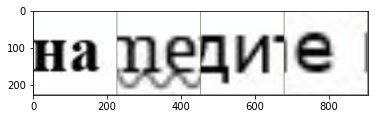

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.6576, -2.7494,  4.1584,  6.0718, -2.6432])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.6662, -2.7562,  8.5176,  5.3365, -5.1950])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.0766,  9.6134, -0.3373, -1.0342, -7.5702])
Predict class - times new roman, real class - liberation serif, probability (arial,calibri) - tensor([-2.5870, -0.3438,  1.7389,  3.3615, -1.6882])


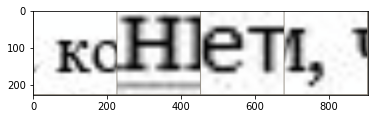

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.2877,  5.0901,  1.2839,  1.1980, -4.2727])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.9744, -0.0485, -5.0831,  0.0989, -0.9458])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.5600,  2.3321, -3.5457, -0.3556, -4.8376])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 4.9332,  1.3678, -2.8377, -0.6871, -2.7885])


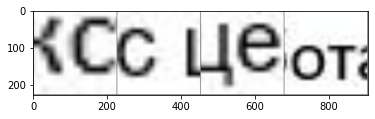

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.1115,  0.4271,  1.6053, -1.1634, -2.3028])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.5621, -2.2826,  7.1027,  1.7346, -2.0663])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.6137,  1.4293, -4.6151, -3.1526,  3.4923])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.9485,  1.5521, 10.5369, -2.7620, -5.5900])


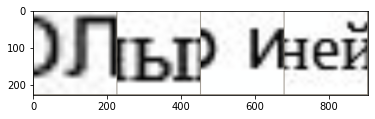

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.5320,  3.4530,  6.9203,  0.5301, -6.5721])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.1847,  1.8680, -4.4629,  0.5423, -3.3226])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-0.8648,  1.3293,  3.9973, -1.1234, -2.4039])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.2411,  2.8345, -1.2143, -2.3988,  1.0216])


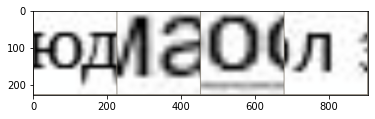

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.5765,  0.3863,  5.0536,  1.2248, -3.2257])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.8251,  1.4147, -3.0881, -4.4229,  9.6776])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.0875,  2.9105,  4.5947, -1.1853, -1.6555])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.9562,  1.7888, -2.2272, -1.6360, -0.7976])


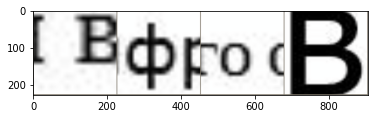

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.9303,  0.4797, -2.7848,  8.2177, -1.3830])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([ 1.3890,  2.5903,  5.5176, -1.1412, -7.7645])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.0706, -0.8428,  9.3856,  0.4883, -7.0532])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 1.2601, -0.0985, -0.2484,  0.0106, -1.9578])


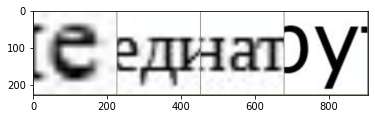

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.7977,  1.7908, -5.5513, -4.5370,  8.7947])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.0895, -2.9371,  4.7715, 10.1159, -8.0562])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 4.8277,  1.6203, -2.8677, -0.2806, -2.6090])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.5825, -1.3725,  2.8548,  4.9817, -1.3426])


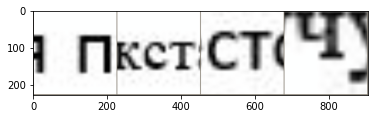

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.5807,  3.6529,  3.4900,  0.7852, -4.0483])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.8534,  0.5871,  7.6355,  2.1750, -4.5423])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 2.8134,  1.7672, -2.9424, -1.3740, -0.5962])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.3431, -0.3174, -1.7053, -3.4052,  6.5582])


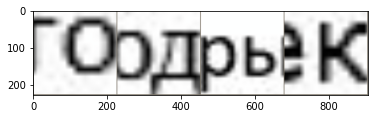

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.1940, -1.5365,  6.1569,  2.1433, -1.6959])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.0889,  6.1970,  1.2947, -0.0981, -5.2072])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.2924,  6.3634,  0.6914, -1.9843, -3.3846])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.9300,  2.3151,  4.2955, -0.0491, -2.8839])


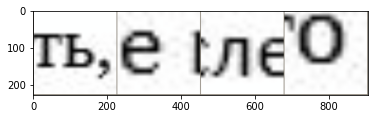

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.1971, -2.7722,  6.8203,  2.1691, -4.1928])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.0450, -2.4251,  6.1617,  4.5327, -5.0881])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.8162, -0.2174,  8.8745, -1.1911, -0.7897])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.9293,  3.3725,  6.8499, -2.7428, -0.9703])


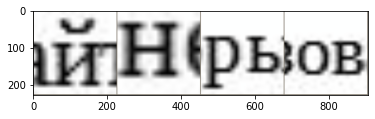

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.1752, -5.3892, -3.6710,  3.6587, 12.5938])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.6935, -2.2811, -3.2912, -0.3175, 13.9596])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 3.1766, -0.4702, -5.8985, -0.9322,  4.8555])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.3002, -0.7499, -5.6597,  0.1364, 11.6473])


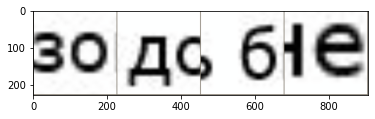

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.5181, -4.8235, -2.1166,  2.3257, 11.1332])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.0435,  5.8407, -2.9325, -1.7532, -1.6433])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.7071, -1.1541, -1.8584, -1.6844,  6.9766])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.1270,  3.0405, -0.5219, -0.6068, -1.3844])


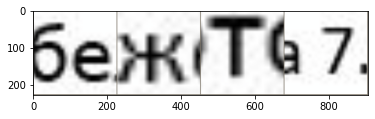

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 1.2435e+00, -2.0094e+00, -7.1744e+00,  7.2958e+00,  1.9423e-03])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.1956, -1.0319,  9.3049, -1.8770, -1.0399])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.2849,  2.7147, -3.2977, -3.2034,  1.8697])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.1145, -0.1924,  8.4121,  1.2130, -5.2567])


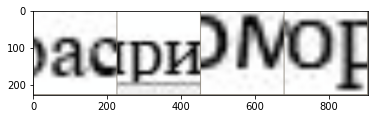

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.2532,  0.0475, -1.8126, -3.1277,  8.9229])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.7813,  0.8215,  7.4829,  3.2365, -5.9513])
Predict class - times new roman, real class - liberation serif, probability (arial,calibri) - tensor([-4.1218, -0.3140,  4.2506,  4.6955, -3.6428])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-7.9272, -2.9363,  1.4042, 10.8478,  1.0655])


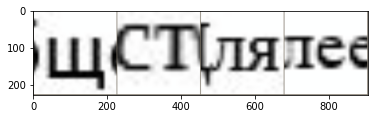

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.0097,  3.4094, -2.8589, -3.4768,  2.0657])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.4849,  0.3920,  7.6912,  3.4407, -5.4365])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 2.8266,  1.1683, -4.6161, -2.8713,  3.8501])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-0.0683, -0.5364,  0.1852,  2.7340, -2.9423])


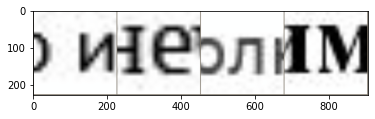

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.4222, -1.2859,  9.4559,  0.3117, -1.0229])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.1405, -1.3644,  8.5373,  1.8270, -5.0914])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.1418, -6.4562, 10.4077,  3.2217, -3.6939])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.6297, -0.5362, -1.5880, -4.8594, 10.1038])


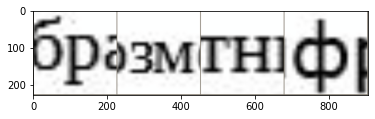

Predict class - calibri, real class - liberation serif, probability (arial,calibri) - tensor([-1.4957,  4.8095,  4.3798, -1.0666, -4.1496])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-9.3951,  2.3099, 12.9304,  4.5453, -5.5331])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.4948,  6.6246,  3.3254, -4.2279, -2.8911])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.6642,  2.6486,  5.6816, -2.4149, -2.8913])


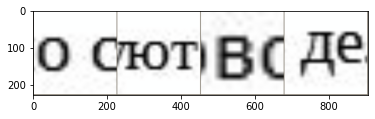

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.9011, -0.1178,  3.9954,  3.7122, -2.9545])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.0705,  0.1872, -5.4632, -0.8143, -0.1514])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.0977, -2.7159, -4.3818,  0.3144,  9.4522])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.1010,  0.2481, -0.8639,  2.9748, -5.4347])


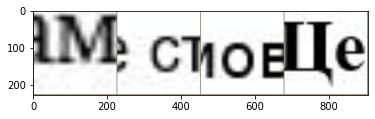

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.9642,  0.4624,  7.1155,  3.6488, -5.6019])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.5022,  2.4223, -4.6989, -5.5246,  8.3589])
Predict class - liberation serif, real class - times new roman, probability (arial,calibri) - tensor([-2.4903, -2.0288,  3.8278,  3.6829, -2.9460])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 7.2139, -1.4911, -4.5134,  0.1449, -1.4687])


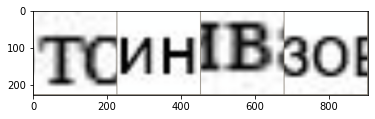

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.8839,  2.5928, -3.3556, -4.9247,  2.7446])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([ 0.0560,  2.1698,  4.9664, -1.6314, -4.1872])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.0567,  6.3568,  0.1246, -0.8389, -4.6222])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.3957,  3.0413, -5.6377, -6.3994,  7.8100])


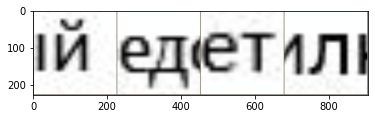

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.1751,  0.7658,  7.8389, -0.9517, -0.4845])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-4.9950, -1.5519, -1.9731, -0.0459, 12.3951])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-0.6879, -1.0281,  6.1384,  3.0314, -6.7339])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.8611, -2.5689, -1.5816, 10.9537, -4.7871])


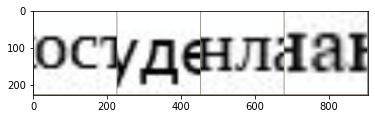

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 4.6577,  7.6117, -3.8622, -5.5684, -2.4403])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-2.6969, -2.4978,  4.9076,  6.3214, -4.6971])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.7000, -1.4238, -2.1604, -1.7311,  9.9019])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 2.0166, -1.3084, -0.9498,  3.4256, -3.3979])


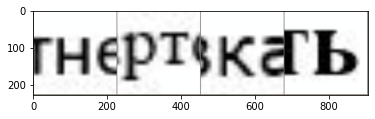

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.4468, -1.8103, -0.0445,  7.5665, -5.4232])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.3998,  5.4556,  0.6036, -0.5814, -4.2253])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.4940,  2.9016,  4.2666, -1.6497, -1.9089])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.7454,  2.3633, -0.6516,  3.5567, -6.0499])


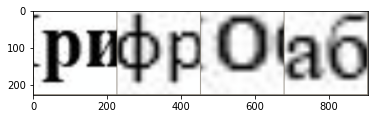

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.0748,  1.2483, -1.0105, -1.0373,  2.1014])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.3042,  1.7710,  5.5715,  0.7486, -4.8241])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.2576, -3.6786, -2.5588, -1.0381, 12.5275])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.6044, -3.3935, -2.0400,  8.5021,  1.6098])


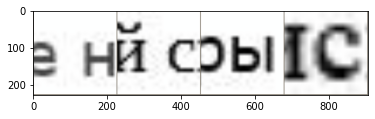

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-5.1273,  0.9307,  9.6818, -0.4724, -2.2680])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.5357,  5.6794,  2.4779, -2.4852, -2.6893])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-0.1082,  5.6458,  0.3849,  0.2676, -5.5319])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.7682, -2.6157, -0.6579,  6.6138, -1.3876])


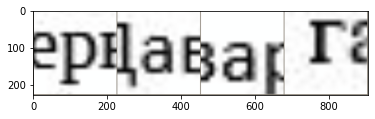

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.2479,  6.9163,  2.0428,  0.3762, -7.4667])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.9429, -1.5192,  9.6183,  2.6916, -2.6535])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.8407, -0.4775,  7.7481, -0.5502, -3.2895])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.3462,  0.4185, -4.7906, -5.0988, 12.1266])


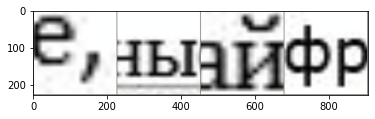

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-0.7861, -2.8329,  6.8204,  3.3176, -5.4765])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.0349, -1.2401,  7.4434,  3.8904, -5.1303])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 7.2225,  1.1206, -2.1131, -4.3418, -2.0736])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.2406, -4.6916, -1.8470,  1.3854, 11.6854])


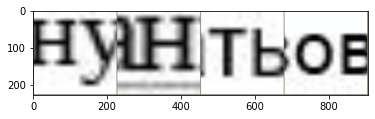

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.0158, -3.2676,  6.1190,  3.3440, -1.8397])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.5632, -2.0355,  6.4790,  5.6637, -7.0971])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 8.3626,  3.3355, -3.9906, -2.3055, -4.8337])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.4734,  3.1877, -3.6349, -4.4942,  3.4019])


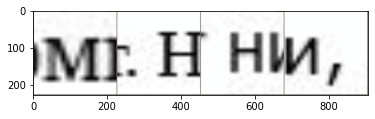

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-0.6604, -2.2858,  4.0451,  2.7978, -3.5601])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 3.9378,  3.9030, -2.3460, -3.9336, -1.2548])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.3394,  6.2133,  3.0560, -1.0483, -3.4900])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.1198,  5.9559, -2.5274, -1.6719, -1.8897])


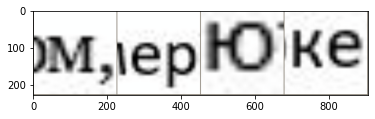

Predict class - liberation serif, real class - times new roman, probability (arial,calibri) - tensor([ 0.8147,  0.0304,  3.9327,  1.6597, -5.1510])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.4872,  5.3218, -1.9889, -2.9360, -1.7781])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.2130,  0.9377,  6.1302,  3.6654, -4.5481])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-6.9645, -5.3528, -2.4712,  3.6967, 13.8338])


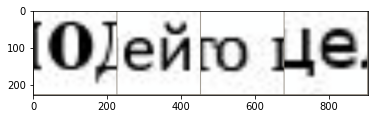

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 0.8051,  2.4639, -8.4766, -2.7196,  8.7847])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.9332,  1.3157, -1.5339,  5.3622, -6.8166])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.9148,  0.3131,  7.4903,  2.4663, -4.3043])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.7357,  5.2159,  0.2817,  0.1810, -4.3832])


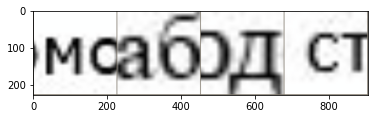

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.1201, -4.0522, -1.2198,  1.3329, 10.2743])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.4591,  1.3818,  5.9296,  0.5078, -2.8584])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.6790, -0.8455, -3.0208, -2.4656,  8.0680])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.2863,  1.3330,  8.0447,  2.8907, -5.8681])


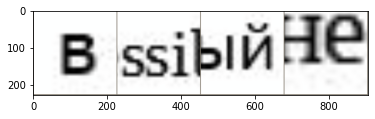

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.5576,  3.7142, -1.7522, -3.3929, -2.5228])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.8918,  0.8421, -4.9363,  0.1561, -1.5877])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.3307, -0.3317, -7.7992, -1.6786, 11.6161])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 4.5996,  4.1170, -2.9832, -2.8753, -3.2078])


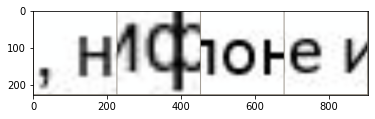

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 3.2440,  4.3163, -6.9296, -5.6500,  4.3895])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 5.4031,  1.3278, -3.6698, -0.9918, -3.1491])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.4914, -1.1769,  7.3852,  2.3091, -2.0487])
Predict class - times new roman, real class - liberation serif, probability (arial,calibri) - tensor([-3.9149, -1.2286,  4.2811,  5.1906, -3.4485])


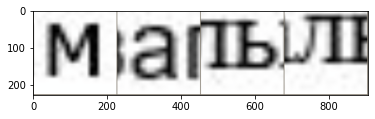

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.0807,  6.3508,  1.5854, -1.2786, -2.1344])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 7.1747,  1.8592,  2.6465, -3.2234, -8.8406])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.5632, -0.1227, -2.1352,  4.0524, -2.6459])
Predict class - times new roman, real class - liberation serif, probability (arial,calibri) - tensor([-2.3737,  3.8250,  1.5645,  4.2740, -6.0191])


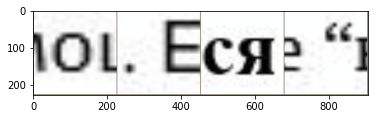

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-0.9355, -1.1955, -4.0966, -2.9527, 10.6216])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.1453,  0.3200,  5.0828,  1.9538, -2.6721])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.2967, -0.4952,  6.7678,  0.8382, -4.7324])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.4056,  2.0693, -2.9985, -3.7033,  2.3852])


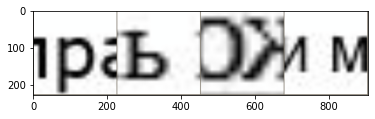

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.3276, -2.2552, -0.6089, -1.4643, 10.0891])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.6121, -1.2493, -5.4748,  7.7760,  2.3934])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.4209,  5.4070, -0.7221, -1.3803, -4.0933])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-2.3575, -3.4925, -4.4067,  0.5432, 11.9068])


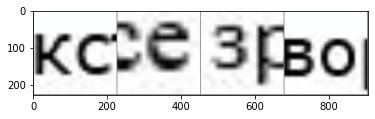

Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([ 0.1363,  1.5389, -2.0397,  2.7876, -3.0143])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.7385,  6.4971, -1.1870, -3.6531, -2.5595])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([ 0.0560,  2.1698,  4.9664, -1.6314, -4.1872])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3746, 10.5079, -4.3910, -8.8726,  1.8874])


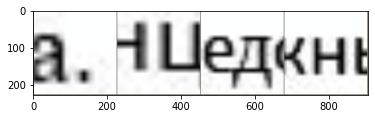

Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 2.3286,  2.0976, -2.3549, -1.4704, -2.0219])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-2.7856, -1.5008,  6.4249,  0.8579, -1.1803])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([ 1.5930,  0.6760, -5.7069, -3.9781,  7.9530])
Predict class - arial, real class - calibri, probability (arial,calibri) - tensor([ 4.6073,  2.9993, -0.3845, -3.7971, -3.0134])


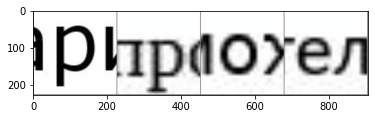

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.2082, -0.6244, -3.5335, -0.3331, -2.2360])
Predict class - calibri, real class - verdana, probability (arial,calibri) - tensor([-0.6113,  0.8719,  0.6833, -0.7819, -0.0621])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-1.3254, -1.1839,  6.4330,  1.5536, -5.5096])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.1048, -1.0899, -4.2708, -2.5865, 10.4004])


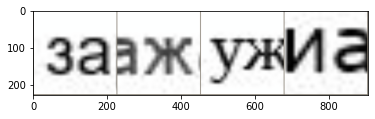

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.2550,  1.9863,  0.8143,  0.4802, -3.6853])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.4801, -0.1392, -5.9179,  1.9689, -3.6027])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-3.1007,  0.5170,  1.6507,  5.7563, -4.6945])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.7382,  6.3554, -4.9727, -3.1485, -1.3063])


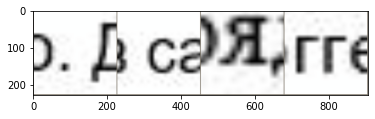

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-1.3702,  8.2860,  3.7936, -3.3009, -4.4502])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.8530,  6.1122,  7.7897, -1.6098, -4.7579])
Predict class - times new roman, real class - verdana, probability (arial,calibri) - tensor([ 1.1700, -1.4902, -1.6125,  1.5231,  1.0338])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.1291, -1.7096,  7.1454,  1.6756, -1.9836])


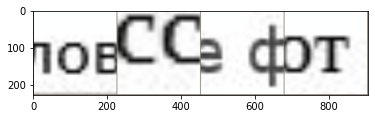

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 3.4648,  4.5864, -4.1900, -4.6348,  0.2910])
Predict class - liberation serif, real class - verdana, probability (arial,calibri) - tensor([ 0.2919, -0.4795,  1.3440, -0.3790, -0.7754])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-4.7844, -2.2218,  4.1733,  6.5527, -1.9709])
Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-3.9530, -3.8801, -2.6193,  2.1103, 11.2377])


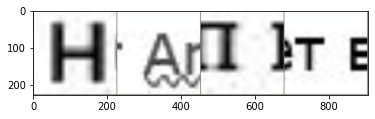

Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 3.6577,  0.0120, -2.0010,  1.3170, -3.3451])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 2.2536,  3.3717,  0.3375, -3.5131, -2.2492])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.5183,  2.5466,  1.4273,  2.2788, -2.8023])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 0.9371,  3.6440, -2.5534, -2.1810,  1.1166])


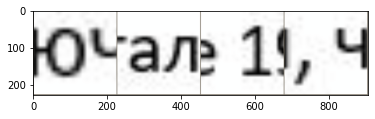

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-3.1223,  6.3566,  3.3709, -1.1449, -2.5418])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 2.9543,  1.9390, -2.8449, -4.1733,  1.0257])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-5.0180, -3.9895,  1.5461,  8.9390,  0.8192])
Predict class - times new roman, real class - times new roman, probability (arial,calibri) - tensor([-1.7445, -3.4521,  1.9389,  9.2314, -5.0852])


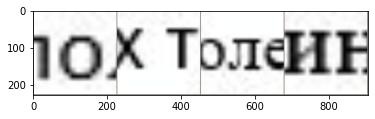

Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-4.2037,  3.9220,  9.2106, -2.1065, -4.6706])
Predict class - liberation serif, real class - liberation serif, probability (arial,calibri) - tensor([-3.9791,  2.4236,  5.4763,  2.7931, -4.8059])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3633,  3.7603, -2.4609, -2.2551,  0.1604])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.6228,  1.9737, -1.1677, -5.8107, -2.6300])


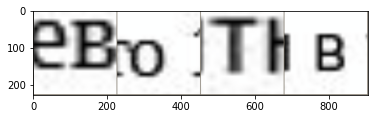

Predict class - verdana, real class - verdana, probability (arial,calibri) - tensor([-1.1107, -0.9534, -0.5021,  1.2362,  1.9253])
Predict class - arial, real class - verdana, probability (arial,calibri) - tensor([ 4.2107,  2.2468, -2.5986, -2.5241, -2.1369])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 4.6539e+00,  2.7467e+00, -3.2894e-03, -5.2781e+00, -8.2809e-01])
Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([-2.1200,  4.3028,  2.4465,  0.7178, -4.8064])


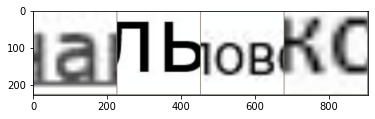

Predict class - calibri, real class - calibri, probability (arial,calibri) - tensor([ 1.3569,  2.6922, -0.8881, -0.2313, -2.7887])
Predict class - arial, real class - arial, probability (arial,calibri) - tensor([ 6.4114, -0.0895, -2.8971, -1.4408, -2.3017])


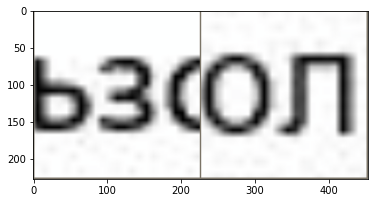

Accuracy of the network on the 194 test images: 89 %


In [13]:
# Visualization results of analysis test data
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for printdata in list(zip(predicted,labels,outputs))[:10]:
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += int((predicted == labels).int().sum())
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))

Pickle

In [14]:
 # Save a dictionary into a pickle file.
import pickle
pickle.dump(model_ft, open("model.pcl", "wb"))

In [15]:
model = pickle.load(open("model.pcl", "rb"))

Проверка на валидационной выборке

In [16]:
#Create function to get your(my) images dataset and resize it to size for model
def get_dataset(data_dir, data_transforms):
    
    # create train and test datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['valid']}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['valid']}

    return dataloaders['valid']

Проверка на валидациооной выборке (194 изображения)

In [17]:
data_dir = '/content/drive/MyDrive/datasets'
dataloaders_test = get_dataset(data_dir, data_transforms)

In [18]:
correct = 0 
total = 0 

for data in dataloaders_test:
        
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
            
        total += labels.size(0)
        correct += int((predicted == labels).int().sum())

print('Accuracy of the network: {}'.format(correct / total))

Accuracy of the network: 0.9479166666666666


Preprocess img

In [19]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [20]:
#preprocess input image
def preprocess_input(image_pth):

  try:
    test_img = Image.open(image_pth).convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)
  except:
    test_img = image_pth.convert('RGB')
    transformed_img = transform(test_img)
    input_img = transform_normalize(transformed_img)

  return input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [21]:
#0-arial, 1-calibri, 2-tnr, 3-verdana
def pred_font(output):
  if (output == output.max().item()).nonzero()[0][1] == torch.tensor(0):
    return 'arial'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(1):
    return 'calibri'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(2):
    return 'liberation serif'
  elif (output == output.max().item()).nonzero()[0][1] == torch.tensor(3):
    return 'times new roman'  
  else:
    return 'verdana'

Get chunk of image for prediction

In [22]:
#get word in the Image
def word_detection(image: Image):

  coordinate = list()
  chunk = list()
  amendment = 2

  cv_image = np.array(image)
  
  kernel_len = int(np.array(cv_image).shape[1]/100)
  hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 8))
  cv_text_detected_image = cv2.morphologyEx(cv_image, cv2.MORPH_OPEN, hor_kernel)
  #detects the contours
  contours, c = cv2.findContours(cv_text_detected_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  
  #ellipsis = [cv2.fitEllipse(i)\
   #           for i in contours if i.shape[0] > 10 and (cv2.contourArea(i) < (cv_image.shape[0] * cv_image.shape[1]*0.1))]
  
  #the code below is get coordinate of text
  if len(contours) !=0:
    for contour in contours:
        if cv2.contourArea((contour)) > 500:
            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(cv_image,(x,y),(x+w,y+h),(0,255,),1)
            coordinate.append([x-amendment, y-amendment, x+w+amendment, y+h+amendment])

  #the code below is dividing the image into chunk of text
  chunk.extend([image.crop(tuple(coordinate_elem)) for coordinate_elem in coordinate])

  return chunk

In [23]:
#get chunk of text to predict
def get_predict_chunk(image):

  font = list()

  chunk = word_detection(image)

  for image in tqdm(chunk):

        input_img = preprocess_input(image)
        font.append(pred_font(model(input_img)))

  return Counter(font)

Прогноз модели на конкретном примере

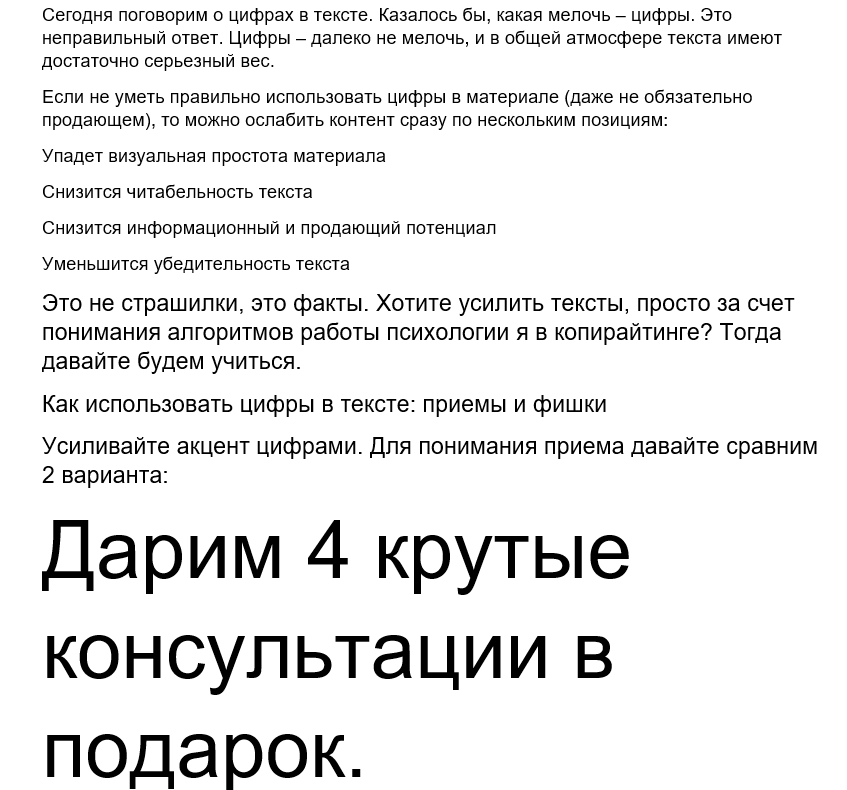

In [25]:
image = Image.open('/content/drive/MyDrive/dataset fonts/arial/pic1.png').convert('L')
image

In [26]:
pred = get_predict_chunk(image).most_common
pred

100%|██████████| 101/101 [00:15<00:00,  6.61it/s]


Counter({'arial': 74,
         'times new roman': 3,
         'calibri': 14,
         'verdana': 9,
         'liberation serif': 1})

In [29]:
pred.most_common()[0][0]

'arial'